<a href="https://colab.research.google.com/github/larunerdman/JSC270_Lab7/blob/main/LAB7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Lab 7: Clustering

###- Prepping our Data
###- KMeans
###- Hierarchical Clustering
###- Evaluating/Understanding our clusters

####Before we begin: 

In [44]:
from google.colab import files
import io
import sys

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering

from scipy.cluster.hierarchy import dendrogram, linkage

import seaborn as sns

#Our Data: Employment counts from different industries from 2001-2020 in the province of Ontario. Data modified from [here](https://data.ontario.ca/en/dataset/labour-force-estimates-by-occupation/resource/0de3deb4-5379-41c6-b0d0-8aeafc9a1493). 

###Some things I did to the data before this script (and for you to consider/make sure you know how to do:

### - Removed total counts (only keeping counts from individual regions)
### - Changed data from "long" format to "wide" format for both male and female counts, then merged the two wide dataframes

In [50]:
uploaded = files.upload()

Saving Lab7_Data_20210302.csv to Lab7_Data_20210302 (3).csv


In [69]:
data = pd.read_csv(io.BytesIO(uploaded['Lab7_Data_20210302.csv']))
data = data.replace('-', 0)
data.head()

,Unnamed: 0,Occupation,MONTH,GEOGRAPHY,LFS.CHARCT.,yr,month,job_num,job_descr,Male_15-19,Male_20-24,Male_25-44,Male_45-54,Male_55-64,Male_65 years and over,Male_15-64 years,"Male_Total, 15 years and over",Female_15-19,Female_20-24,Female_25-44,Female_45-54,Female_55-64,Female_65 years and over,Female_15-64 years,"Female_Total, 15 years and over"
0,1,0 - Management occupations,Dec2001,Central region,Employment,2001,Dec,0,Management occupations,0.0,4.8,98.0,64.5,33.3,5.7,201.1,206.7,0.0,3.8,59.9,23.3,9.8,0.0,96.9,97.6
1,2,0 - Management occupations,Dec2001,Central region,Unemployment,2001,Dec,0,Management occupations,0.0,0.0,1.5,2.7,0.0,0.0,4.4,4.4,0.0,0.0,2.0,0.0,0.0,0.0,3.2,3.2
2,3,0 - Management occupations,Dec2001,Central region,Labour force,2001,Dec,0,Management occupations,0.0,4.8,99.5,67.2,33.5,5.7,205.4,211.1,0.0,3.8,61.8,24.3,10.0,0.0,100.1,100.8
3,4,0 - Management occupations,Dec2001,Central region,Unemployment rate,2001,Dec,0,Management occupations,0.0,0.0,1.5,4.0,0.0,0.0,2.1,2.1,0.0,0.0,3.2,0.0,0.0,0.0,3.2,3.2
4,5,0 - Management occupations,Dec2001,Eastern region,Employment,2001,Dec,0,Management occupations,0.0,0.0,27.1,18.6,13.2,4.2,60.4,64.6,0,0.0,17.7,9.1,2.9,1.8,30.1,31.9


In [71]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64464 entries, 0 to 64463
Data columns (total 25 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       64464 non-null  int64  
 1   Occupation                       64464 non-null  object 
 2   MONTH                            64464 non-null  object 
 3   GEOGRAPHY                        64464 non-null  object 
 4   LFS.CHARCT.                      64464 non-null  object 
 5   yr                               64464 non-null  int64  
 6   month                            64464 non-null  object 
 7   job_num                          64464 non-null  object 
 8   job_descr                        63200 non-null  object 
 9   Male_15-19                       64464 non-null  object 
 10  Male_20-24                       64464 non-null  object 
 11  Male_25-44                       64464 non-null  object 
 12  Male_45-54        

In [58]:
data.columns

Index(['Unnamed: 0', 'Occupation', 'MONTH', 'GEOGRAPHY', 'LFS.CHARCT.', 'yr',
       'month', 'job_num', 'job_descr', 'Male_15-19', 'Male_20-24',
       'Male_25-44', 'Male_45-54', 'Male_55-64', 'Male_65 years and over',
       'Male_15-64 years', 'Male_Total, 15 years and over', 'Female_15-19',
       'Female_20-24', 'Female_25-44', 'Female_45-54', 'Female_55-64',
       'Female_65 years and over', 'Female_15-64 years',
       'Female_Total, 15 years and over'],
      dtype='object')

###Let's make some quick, exploratory plots of our data

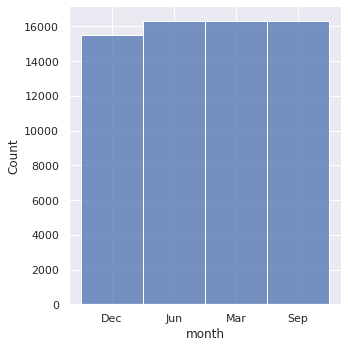

In [62]:
sns.displot(data, x="month")

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout(*args, **kwargs)


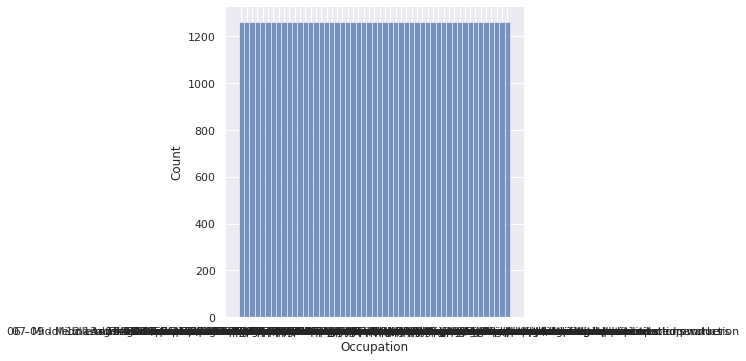

In [64]:
sns.displot(data, x='Occupation')

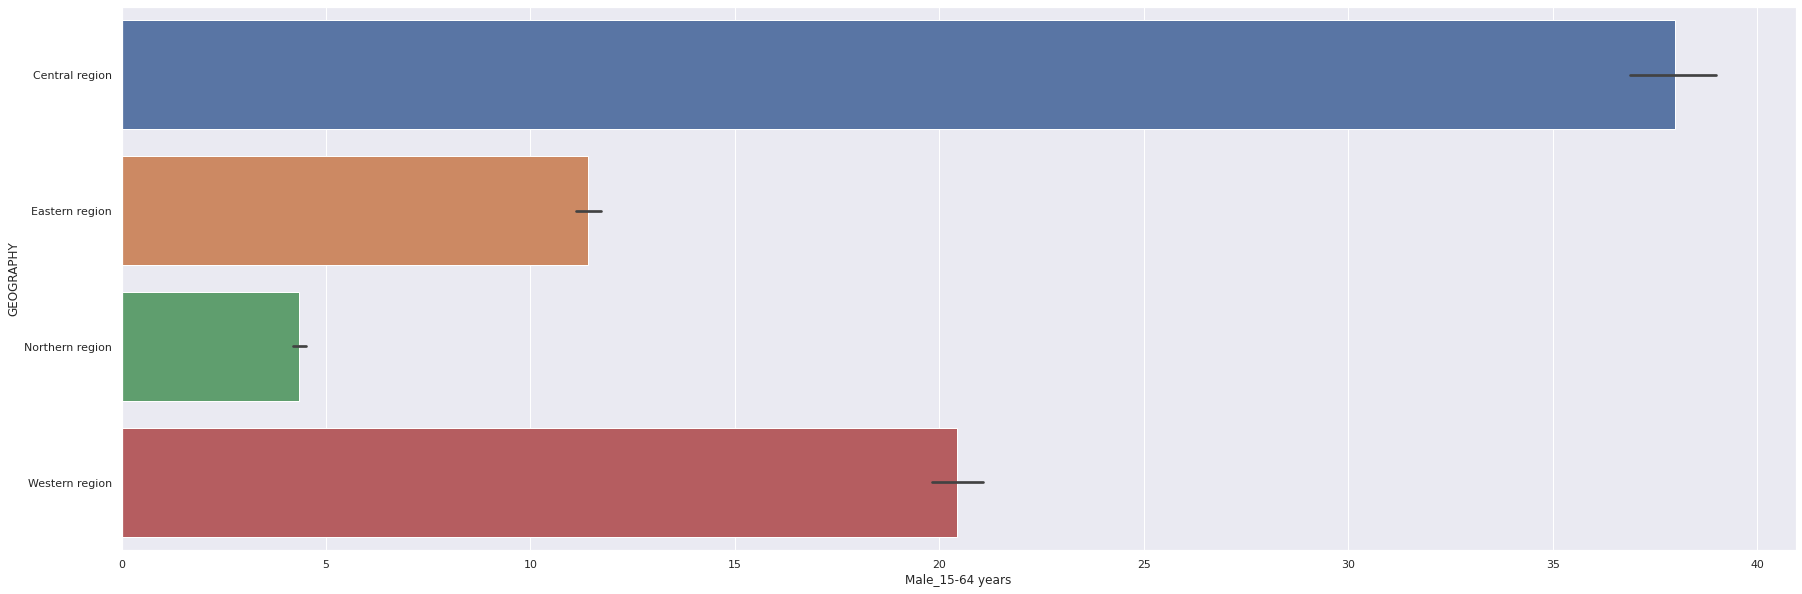

In [72]:
sns.barplot(x='Male_15-64 years', y='GEOGRAPHY', data=data)

###Check out data size

In [73]:
data.shape ## data is *VERY* big, let's sub-sample it

(64464, 25)

In [99]:
data_sub = data.sample(600, random_state=4321) ## sampling approximately 1% of the data
data_sub.head() 

,Unnamed: 0,Occupation,MONTH,GEOGRAPHY,LFS.CHARCT.,yr,month,job_num,job_descr,Male_15-19,Male_20-24,Male_25-44,Male_45-54,Male_55-64,Male_65 years and over,Male_15-64 years,"Male_Total, 15 years and over",Female_15-19,Female_20-24,Female_25-44,Female_45-54,Female_55-64,Female_65 years and over,Female_15-64 years,"Female_Total, 15 years and over"
45311,56640,"7 - Trades, transport and equipment operators ...",Sep2008,Western region,Unemployment rate,2008,Sep,7,"Trades, transport and equipment operators and ...",0.0,8.0,5.2,3.8,0.0,0.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,10.3,10.1
27669,34586,41 - Professional occupations in law and socia...,Sep2012,Eastern region,Unemployment,2012,Sep,41,"Professional occupations in law and social, co...",0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29829,37286,43 - Occupations in front-line public protecti...,Mar2009,Eastern region,Unemployment,2009,Mar,43,Occupations in front-line public protection se...,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0,0.0,0.0,0,0,0.0,0.0
39975,49968,64 - Sales representatives and salespersons - ...,Mar2011,Eastern region,Unemployment rate,2011,Mar,64,Sales representatives and salespersons,0.0,0.0,0.0,0.0,0.0,0.0,9.6,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30662,38327,"44 - Care providers and educational, legal and...",Jun2002,Eastern region,Labour force,2002,Jun,44,"Care providers and educational, legal and publ...",0.0,0.0,1.6,0.0,0,0,3.0,3.0,2.9,0.0,6.0,1.7,0.0,0,12.2,12.2


###Extract features and standardize rows

In [100]:
features = data_sub.iloc[:, 9:]
scaler = StandardScaler()
scaled_feat = scaler.fit_transform(features)

#K-Means

###Do one round of clustering

In [ ]:
kmeans = KMeans(
    init = "random",
    n_clusters = 5,
    n_init = 10,
    max_iter = 300,
    random_state=4321
)

In [ ]:
kmeans.fit(scaled_feat)

In [ ]:
## check out the labels
kmeans.labels_[0:10]

###Let's evaluate using different numbers of clusters

In [101]:
sil_coefs = []
clust_labels = []

for k in range(2, 15):
  print("clustering with " + str(k) + " clusters")
  kmeans = KMeans(n_clusters=k, n_init = 2, init="random", max_iter = 300, random_state=4321)
  kmeans.fit(scaled_feat)
  clust_labels.append(kmeans.labels_)
  score = silhouette_score(scaled_feat, kmeans.labels_)
  sil_coefs.append(score)

clustering with 2 clusters
clustering with 3 clusters
clustering with 4 clusters
clustering with 5 clusters
clustering with 6 clusters
clustering with 7 clusters
clustering with 8 clusters
clustering with 9 clusters
clustering with 10 clusters
clustering with 11 clusters
clustering with 12 clusters
clustering with 13 clusters
clustering with 14 clusters


###Plot silhouette statistics for each number of clusters

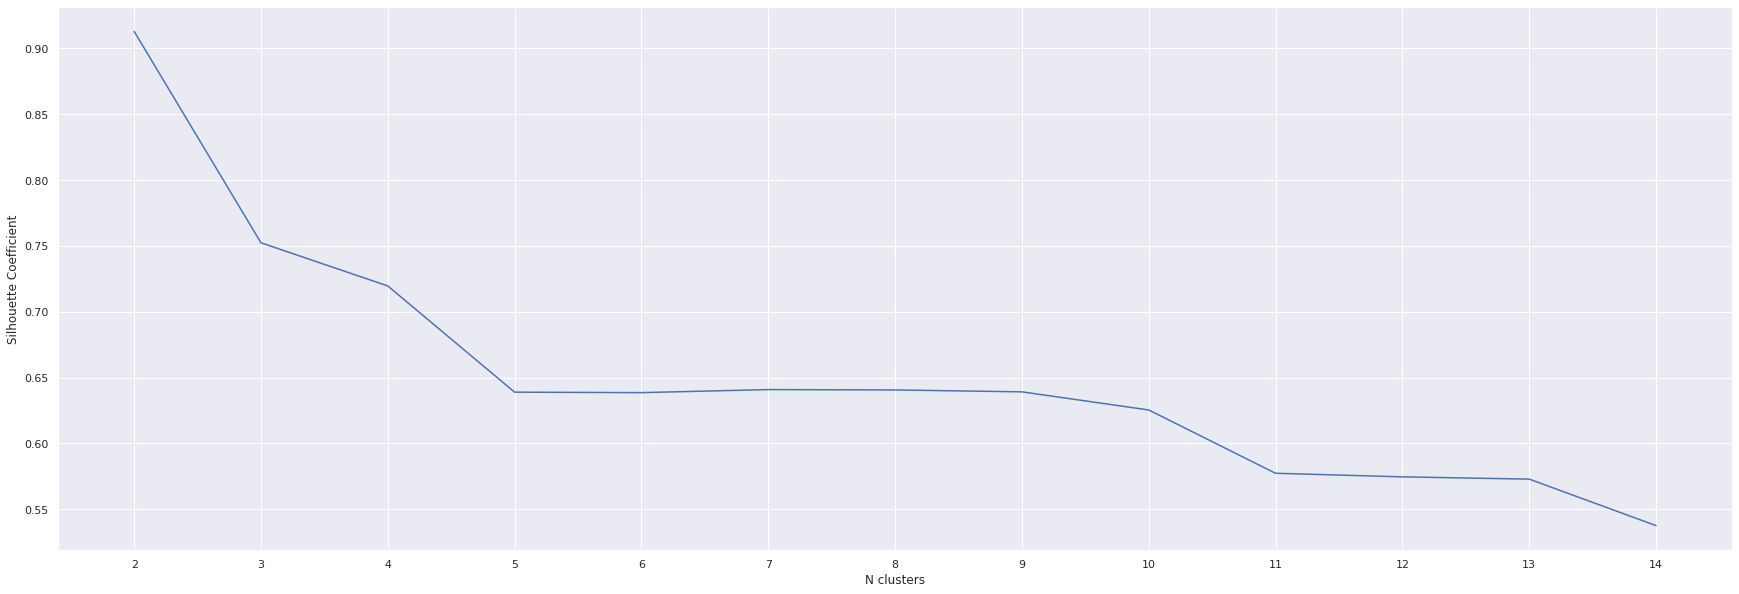

In [102]:
plt.plot(range(2,15), sil_coefs)
plt.xticks(range(2,15))
plt.xlabel("N clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

###Let's see if these clusters make sense in other ways by summarizing the data that composes them

### Let's investigate 2 and 5 clusters

### Check out the distribution of the data used for clustering and data not used for clustering

###Data used for clustering

In [103]:
n_clusters = 5

clust_df = pd.DataFrame(data=scaled_feat,columns=features.columns)
clust_df = clust_df.astype(float)
clust_df = clust_df.assign(clusters = clust_labels[n_clusters-2])

clust_mean_df = clust_df.groupby(['clusters']).mean()

clust_mean_df


,Male_15-19,Male_20-24,Male_25-44,Male_45-54,Male_55-64,Male_65 years and over,Male_15-64 years,"Male_Total, 15 years and over",Female_15-19,Female_20-24,Female_25-44,Female_45-54,Female_55-64,Female_65 years and over,Female_15-64 years,"Female_Total, 15 years and over"
clusters,,,,,,,,,,,,,,,,
0,0.168134,0.477165,0.923605,1.046561,0.786457,0.615867,1.055456,1.083146,0.418560,1.019897,2.285455,1.987859,1.480286,1.931105,2.319982,2.314722
1,-0.141524,-0.208119,-0.321239,-0.325135,-0.269867,-0.145003,-0.330047,-0.330930,-0.153329,-0.200637,-0.323387,-0.300242,-0.241080,-0.187700,-0.317508,-0.316014
2,6.696845,7.200140,4.530458,4.023303,7.817284,4.993557,3.588801,3.598279,8.570526,7.955691,6.392166,6.937365,7.953099,3.826613,5.275974,5.265771
3,0.384307,2.115605,5.686963,5.303359,3.323562,1.256351,5.665866,5.617108,-0.170757,0.035478,0.966568,0.737747,0.319940,-0.077014,0.790880,0.774179
4,0.190277,0.224655,0.481138,0.532455,0.278652,0.085352,0.547584,0.547159,0.098387,0.162732,0.386215,0.352367,0.189953,0.078677,0.436313,0.432694


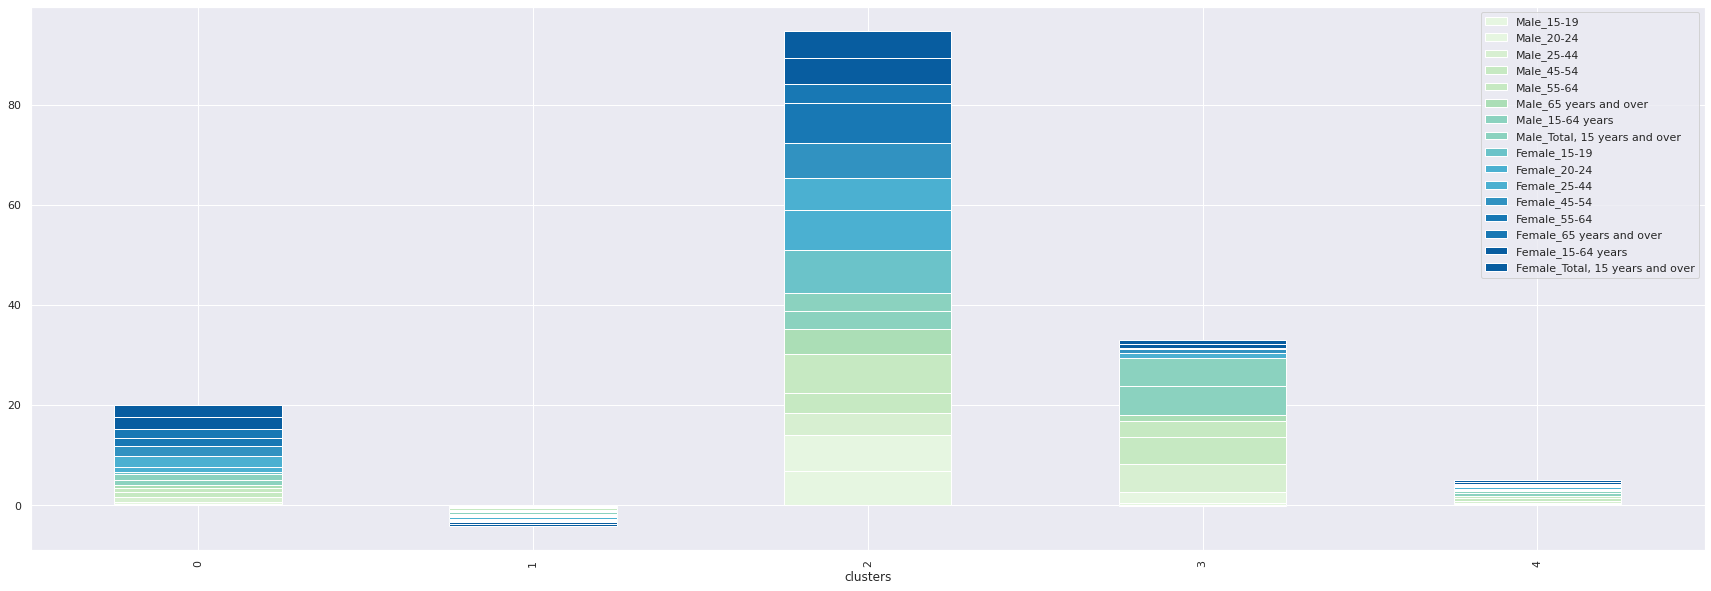

In [104]:
sns.set()
clust_mean_df.plot(kind='bar',
                   stacked=True,
                   colormap=ListedColormap(sns.color_palette("GnBu", 10)),
                   figsize=(30,10))

###Data not used for clustering

In [106]:
# n_clusters = 5

other_dat = data_sub.iloc[:, :9]
other_dat = other_dat.assign(clusters = clust_labels[n_clusters-2])
other_dat.clusters.astype(str)
other_dat.set_index('clusters')

other_dat.head()

,Unnamed: 0,Occupation,MONTH,GEOGRAPHY,LFS.CHARCT.,yr,month,job_num,job_descr,clusters
45311,56640,"7 - Trades, transport and equipment operators ...",Sep2008,Western region,Unemployment rate,2008,Sep,7,"Trades, transport and equipment operators and ...",1
27669,34586,41 - Professional occupations in law and socia...,Sep2012,Eastern region,Unemployment,2012,Sep,41,"Professional occupations in law and social, co...",1
29829,37286,43 - Occupations in front-line public protecti...,Mar2009,Eastern region,Unemployment,2009,Mar,43,Occupations in front-line public protection se...,1
39975,49968,64 - Sales representatives and salespersons - ...,Mar2011,Eastern region,Unemployment rate,2011,Mar,64,Sales representatives and salespersons,1
30662,38327,"44 - Care providers and educational, legal and...",Jun2002,Eastern region,Labour force,2002,Jun,44,"Care providers and educational, legal and publ...",1


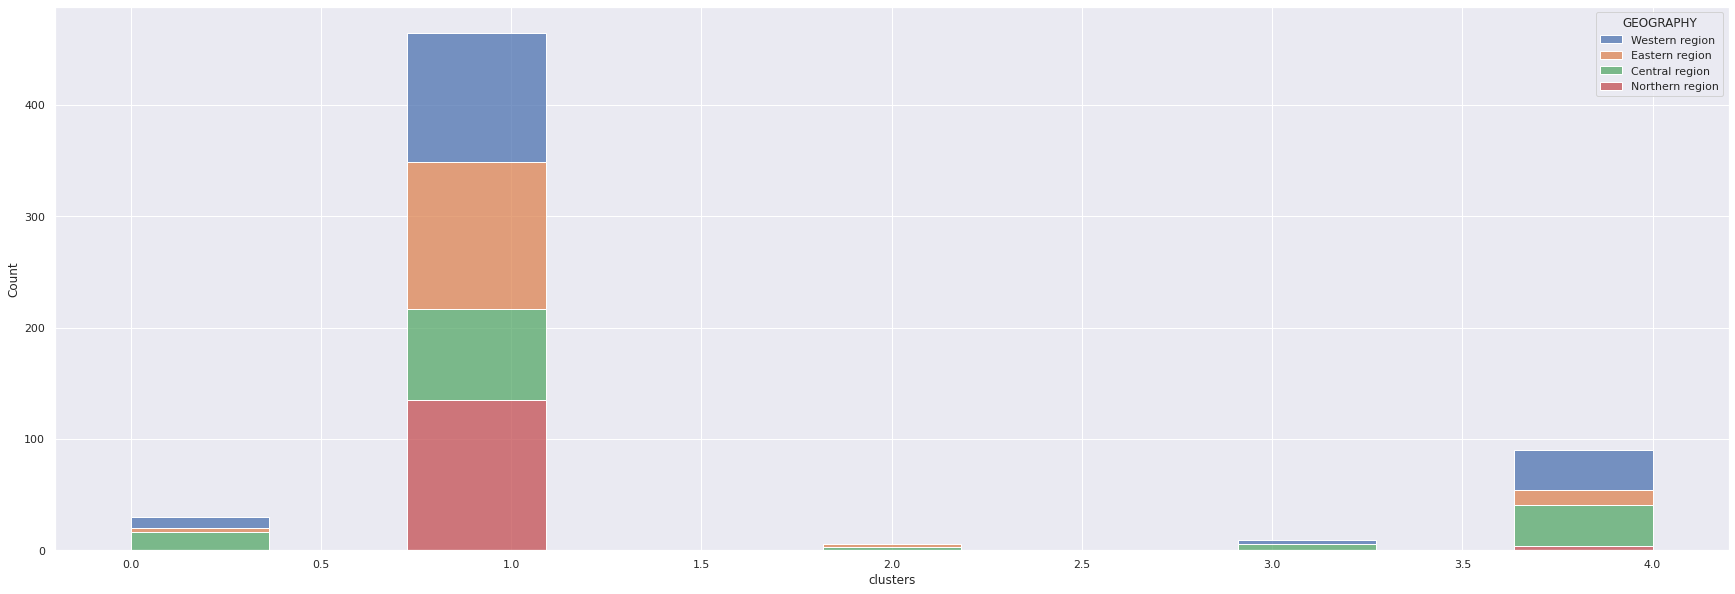

In [107]:
sns.set(rc={'figure.figsize':(30,10)})
sns.histplot(other_dat, x = "clusters", hue = "GEOGRAPHY",
             multiple = "stack")

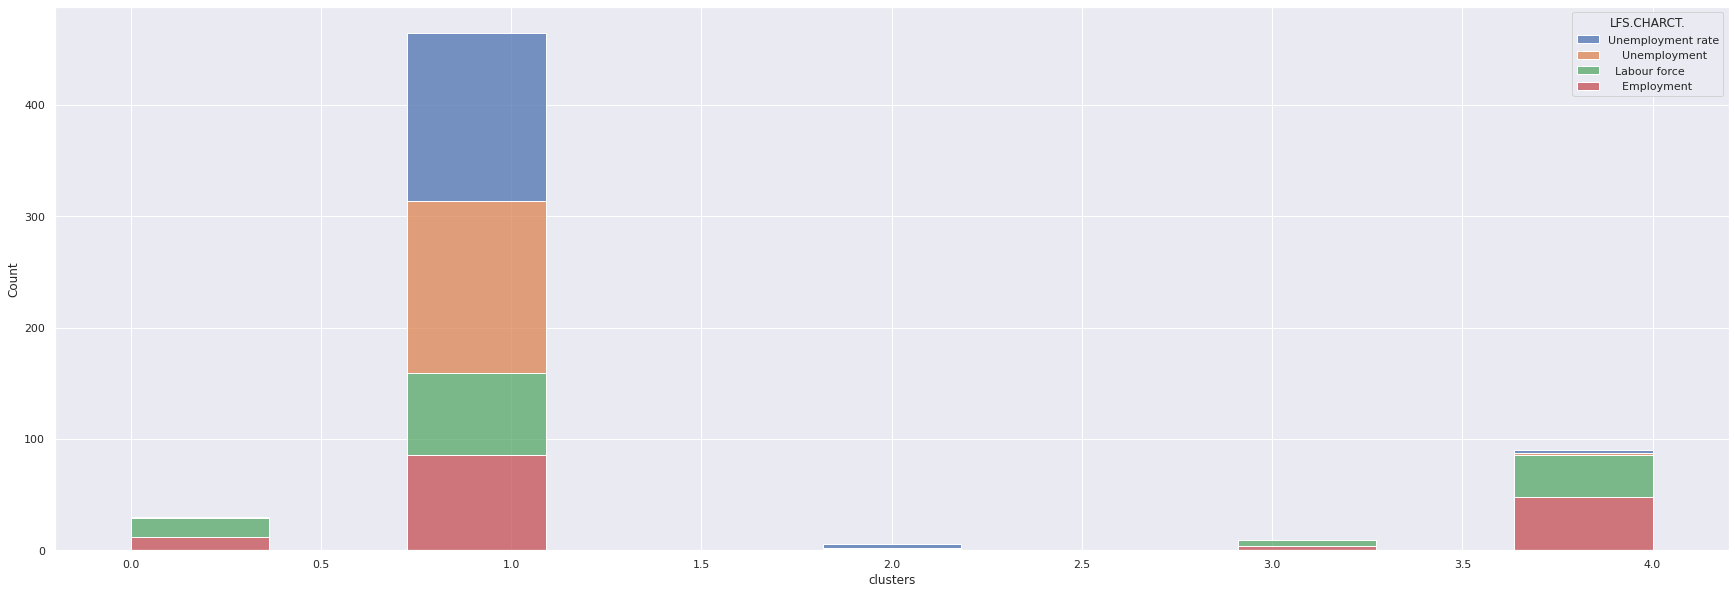

In [108]:
sns.set(rc={'figure.figsize':(30,10)})
sns.histplot(other_dat, x = "clusters", hue = "LFS.CHARCT.",
             multiple = "stack")

###Check out individual data points corresponding to the clusters

In [115]:
other_dat[other_dat['clusters'] == 0] 

,Unnamed: 0,Occupation,MONTH,GEOGRAPHY,LFS.CHARCT.,yr,month,job_num,job_descr,clusters
24130,30163,"4 - Occupations in education, law and social, ...",Dec2008,Central region,Labour force,2008,Dec,4,"Occupations in education, law and social, comm...",0
24780,30977,"4 - Occupations in education, law and social, ...",Mar2009,Western region,Employment,2009,Mar,4,"Occupations in education, law and social, comm...",0
9552,11941,12 - Administrative and financial supervisors ...,Mar2006,Central region,Employment,2006,Mar,12,Administrative and financial supervisors and a...,0
24910,31139,"4 - Occupations in education, law and social, ...",Mar2017,Western region,Labour force,2017,Mar,4,"Occupations in education, law and social, comm...",0
24508,30637,"4 - Occupations in education, law and social, ...",Jun2012,Western region,Employment,2012,Jun,4,"Occupations in education, law and social, comm...",0
36566,45707,6 - Sales and service occupations,Sep2015,Eastern region,Labour force,2015,Sep,6,Sales and service occupations,0
2706,3383,01-05 - Specialized middle management occupations,Dec2012,Central region,Labour force,2012,Dec,01-05,Specialized middle management occupations,0
57632,72041,9 - Occupations in manufacturing and utilities,Mar2009,Central region,Employment,2009,Mar,9,Occupations in manufacturing and utilities,0
24308,30385,"4 - Occupations in education, law and social, ...",Dec2019,Eastern region,Employment,2019,Dec,4,"Occupations in education, law and social, comm...",0
9040,11301,12 - Administrative and financial supervisors ...,Dec2013,Central region,Employment,2013,Dec,12,Administrative and financial supervisors and a...,0


In [116]:
clust_df[clust_df['clusters'] == 0]

,Male_15-19,Male_20-24,Male_25-44,Male_45-54,Male_55-64,Male_65 years and over,Male_15-64 years,"Male_Total, 15 years and over",Female_15-19,Female_20-24,Female_25-44,Female_45-54,Female_55-64,Female_65 years and over,Female_15-64 years,"Female_Total, 15 years and over",clusters
55,0.200410,0.098775,1.845523,1.737683,1.066295,0.545818,1.772592,1.772122,0.564960,1.243571,5.699107,4.582648,2.879459,3.067050,5.192744,5.157562,0
67,-0.182396,-0.036097,1.124819,0.694070,0.586025,0.252064,0.909594,0.907211,0.063335,1.209452,3.105182,2.009819,1.193417,0.958410,2.685947,2.644718,0
96,-0.182396,-0.058575,0.441608,0.286409,-0.057536,-0.154673,0.294408,0.295444,-0.170757,0.288217,2.671179,2.446042,1.400294,-0.197940,2.406590,2.368185,0
102,-0.182396,-0.024858,0.908191,1.085425,0.384312,0.975151,0.874813,0.940963,0.197102,1.050226,3.095089,2.027624,1.834734,2.114761,2.834279,2.829875,0
113,-0.182396,-0.047336,1.016505,1.003893,0.566814,0.613607,0.931332,0.962059,0.174807,0.640789,2.938646,2.036526,1.669233,1.638617,2.626615,2.611053,0
120,0.898467,1.908302,1.220635,1.550159,1.229586,1.201116,1.918236,1.974637,2.214749,1.823608,2.297735,1.618108,1.431325,4.155379,2.851584,2.918847,0
138,-0.182396,-0.283362,1.158146,1.370788,1.738672,0.591011,1.337832,1.354433,-0.170757,-0.223579,1.535706,1.796158,0.924478,1.162472,1.449855,1.447210,0
177,-0.182396,0.593304,1.428931,2.756835,1.248797,1.042940,1.911715,1.953542,-0.170757,-0.052980,1.197588,1.662620,0.893447,0.890390,1.271857,1.266862,0
181,-0.182396,-0.002379,0.941519,0.384248,0.489971,0.726590,0.722647,0.770091,-0.170757,0.333710,2.671179,1.822866,1.555451,2.931008,2.292870,2.332116,0
203,-0.182396,0.020100,0.304133,0.155958,0.345890,-0.154673,0.307451,0.301773,-0.170757,0.447443,2.782203,2.944584,2.951866,3.679235,2.987554,3.034269,0


#Hierarchical clustering

###First, for hierarchical clustering, we want to assess the dendrogram of our data

###Because we have options for different linkage conditions, we may want to assess the impact here or think carefully about our own data and which linkage type AND distance metric is most likely to be appropriate

###Which distance metric and linkage type should we choose here and why? 

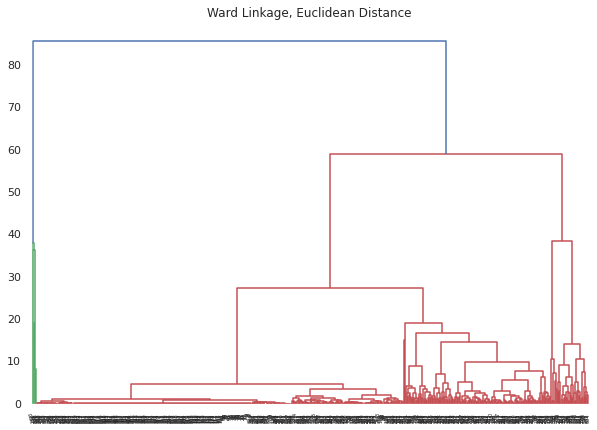

In [123]:
# sys.setrecursionlimit(10000)

plt.figure(figsize=(10,7))
plt.title("Ward Linkage, Euclidean Distance")
dend = dendrogram(linkage(scaled_feat, method = "ward", metric = "euclidean"))

###Some other distance metrics and linkage options

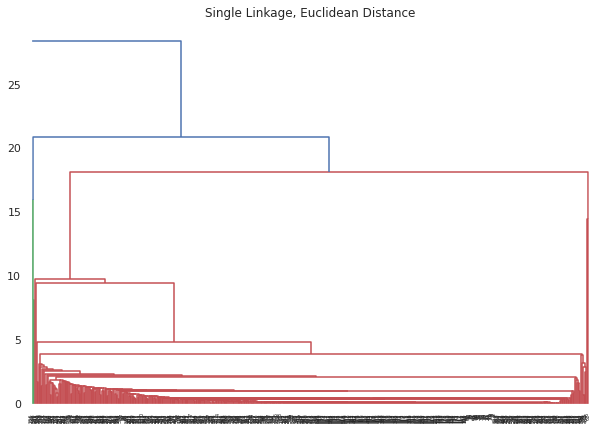

In [119]:
plt.figure(figsize=(10,7))
plt.title("Single Linkage, Euclidean Distance")
dend = dendrogram(linkage(scaled_feat, method = "single", metric = "euclidean"))

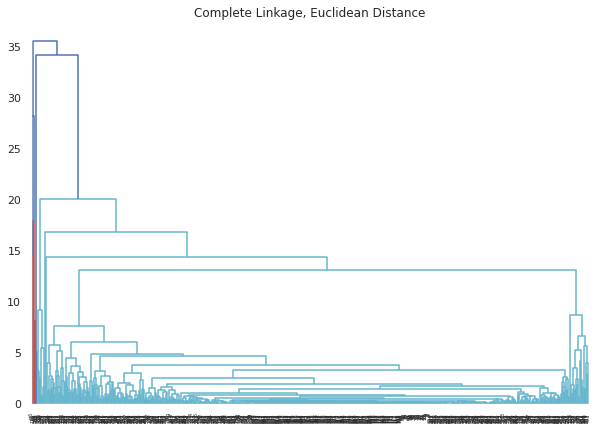

In [120]:
plt.figure(figsize=(10,7))
plt.title("Complete Linkage, Euclidean Distance")
dend = dendrogram(linkage(scaled_feat, method = "complete", metric = "euclidean"))

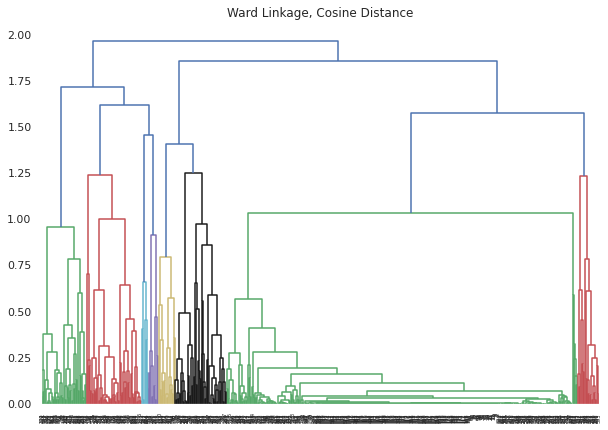

In [124]:
plt.figure(figsize=(10,7))
plt.title('Complete Linkage, Cosine Distance')
dend = dendrogram(linkage(scaled_feat, method = "complete", metric = "cosine")) ## Manhattan distance

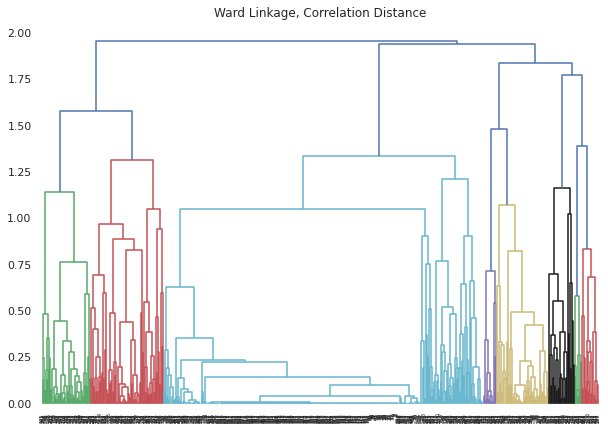

In [125]:
plt.figure(figsize=(10,7))
plt.title('Complete Linkage, Correlation Distance')
dend = dendrogram(linkage(scaled_feat, method = "complete", metric = "correlation")) ## Manhattan distance

###Now with our distance metric and linkage chosen, let's generate clusters and make sense of them

In [132]:
hcluster = AgglomerativeClustering(n_clusters=8, affinity="cosine",linkage="complete")
h_clusts = hcluster.fit_predict(scaled_feat)

###Concatenate cluster labels with data used for clustering to see what your clusters look like

In [133]:
hclust_df = pd.DataFrame(data=scaled_feat,columns=features.columns)
hclust_df = hclust_df.astype(float)
hclust_df = hclust_df.assign(clusters = h_clusts)

hclust_mean_df = hclust_df.groupby(['clusters']).mean()

hclust_mean_df

,Male_15-19,Male_20-24,Male_25-44,Male_45-54,Male_55-64,Male_65 years and over,Male_15-64 years,"Male_Total, 15 years and over",Female_15-19,Female_20-24,Female_25-44,Female_45-54,Female_55-64,Female_65 years and over,Female_15-64 years,"Female_Total, 15 years and over"
clusters,,,,,,,,,,,,,,,,
0,-0.143706,-0.055510,0.138254,0.135797,0.037120,-0.075791,0.151531,0.148314,-0.170757,-0.215928,-0.272334,-0.245433,-0.226318,-0.197940,-0.251639,-0.251075
1,0.856294,1.035637,0.780319,0.663945,0.978869,0.652289,0.782334,0.790292,1.268558,1.575516,2.063455,1.904497,1.707452,1.174001,2.075653,2.066791
2,-0.169618,-0.274471,-0.372961,-0.371543,-0.303592,-0.154673,-0.384248,-0.384932,-0.159521,-0.210551,-0.366361,-0.341225,-0.264951,-0.197940,-0.359295,-0.357425
3,-0.009834,0.584129,1.951371,2.036190,1.327404,0.598389,2.006164,2.006323,-0.167117,-0.021414,0.586646,0.551804,0.281262,0.125505,0.504824,0.500323
4,-0.162325,-0.260883,-0.183823,-0.143230,-0.216652,-0.052498,-0.194035,-0.189933,-0.147008,-0.096990,0.291184,0.281568,0.104169,-0.197940,0.235259,0.228791
5,2.223650,0.425838,-0.225772,-0.343020,-0.263092,-0.154673,-0.175567,-0.183632,0.704300,0.240450,0.019219,-0.124116,-0.199894,-0.197940,0.049361,0.040258
6,0.327074,0.171830,-0.171303,-0.011184,0.006099,0.045871,-0.159100,-0.144131,0.243084,0.336554,0.162415,0.467457,0.240494,2.548392,0.191512,0.223250
7,0.047788,0.969196,-0.023586,0.046795,-0.139716,-0.154673,-0.003160,-0.012900,-0.142889,-0.183773,-0.289742,-0.327588,-0.235753,-0.197940,-0.276830,-0.277315


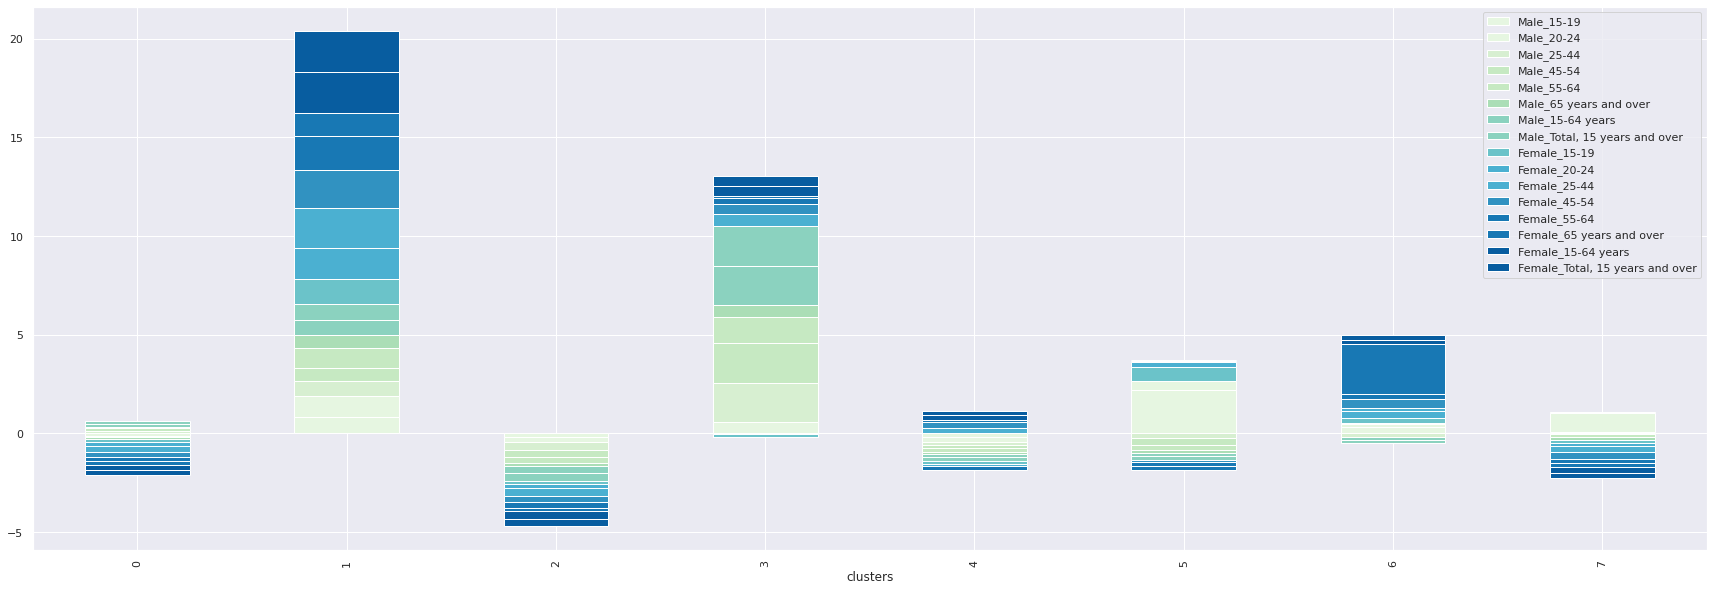

In [134]:
sns.set()
hclust_mean_df.plot(kind='bar',
                   stacked=True,
                   colormap=ListedColormap(sns.color_palette("GnBu", 10)),
                   figsize=(30,10))

###Now concatenate cluster labels with the other data to see if there are some other patterns in the clusters

In [135]:
hother_dat = data_sub.iloc[:, :9]
hother_dat = hother_dat.assign(clusters = h_clusts)
hother_dat.clusters.astype(str)
hother_dat.set_index('clusters')

hother_dat.head()

,Unnamed: 0,Occupation,MONTH,GEOGRAPHY,LFS.CHARCT.,yr,month,job_num,job_descr,clusters
45311,56640,"7 - Trades, transport and equipment operators ...",Sep2008,Western region,Unemployment rate,2008,Sep,7,"Trades, transport and equipment operators and ...",7
27669,34586,41 - Professional occupations in law and socia...,Sep2012,Eastern region,Unemployment,2012,Sep,41,"Professional occupations in law and social, co...",2
29829,37286,43 - Occupations in front-line public protecti...,Mar2009,Eastern region,Unemployment,2009,Mar,43,Occupations in front-line public protection se...,2
39975,49968,64 - Sales representatives and salespersons - ...,Mar2011,Eastern region,Unemployment rate,2011,Mar,64,Sales representatives and salespersons,2
30662,38327,"44 - Care providers and educational, legal and...",Jun2002,Eastern region,Labour force,2002,Jun,44,"Care providers and educational, legal and publ...",2


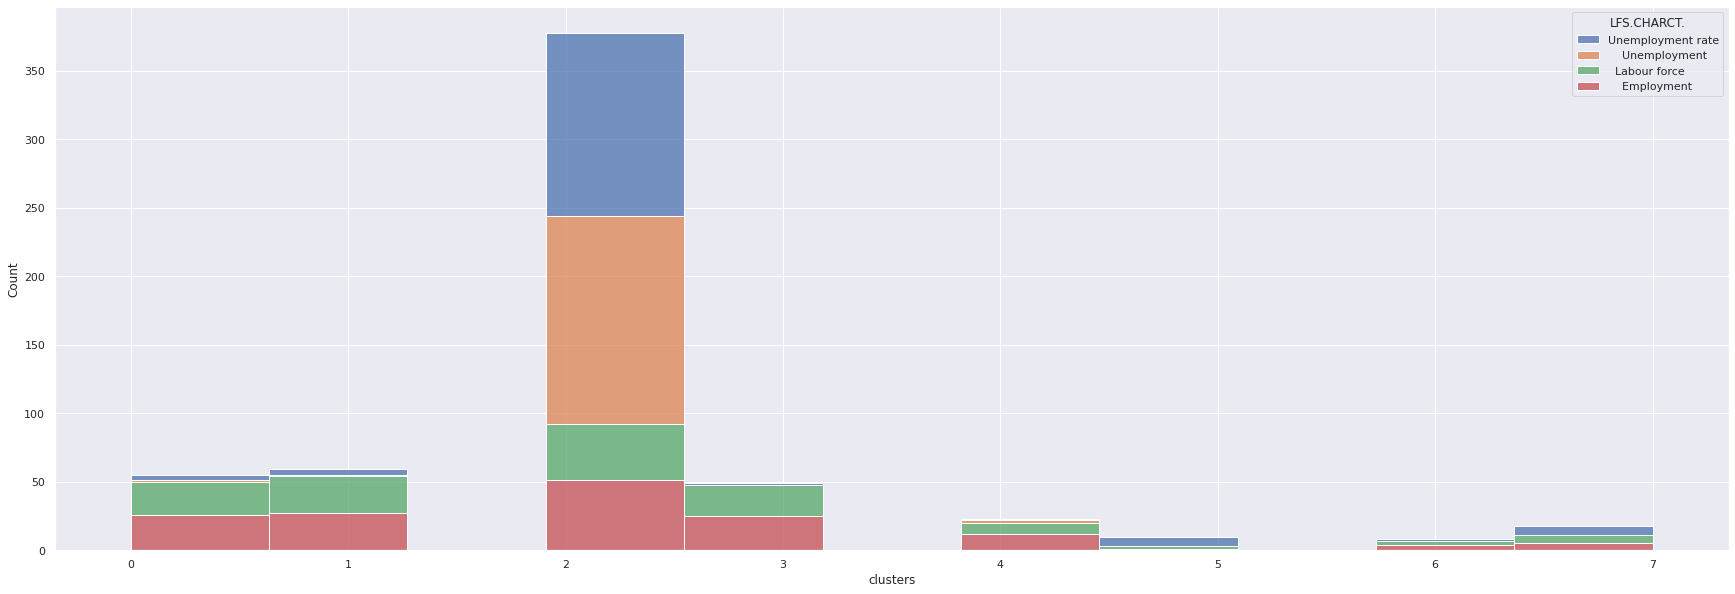

In [141]:
sns.set(rc={'figure.figsize':(30,10)})
sns.histplot(hother_dat, x = "clusters", hue = "LFS.CHARCT.",
             multiple = "stack")

###Check out individual points in the data

In [148]:
hother_dat[hother_dat['clusters'] == 2]

,Unnamed: 0,Occupation,MONTH,GEOGRAPHY,LFS.CHARCT.,yr,month,job_num,job_descr,clusters
27669,34586,41 - Professional occupations in law and socia...,Sep2012,Eastern region,Unemployment,2012,Sep,41,"Professional occupations in law and social, co...",2
29829,37286,43 - Occupations in front-line public protecti...,Mar2009,Eastern region,Unemployment,2009,Mar,43,Occupations in front-line public protection se...,2
39975,49968,64 - Sales representatives and salespersons - ...,Mar2011,Eastern region,Unemployment rate,2011,Mar,64,Sales representatives and salespersons,2
30662,38327,"44 - Care providers and educational, legal and...",Jun2002,Eastern region,Labour force,2002,Jun,44,"Care providers and educational, legal and publ...",2
23700,29625,34 - Assisting occupations in support of healt...,Sep2001,Eastern region,Employment,2001,Sep,34,Assisting occupations in support of health ser...,2
...,...,...,...,...,...,...,...,...,...,...
54153,67690,82 - Supervisors and technical occupations in ...,Sep2008,Northern region,Unemployment,2008,Sep,82,Supervisors and technical occupations in natur...,2
55854,69819,"86 - Harvesting, landscaping and natural resou...",Dec2015,Western region,Labour force,2015,Dec,86,"Harvesting, landscaping and natural resources ...",2
8543,10680,11 - Professional occupations in business and ...,Sep2001,Western region,Unemployment rate,2001,Sep,11,Professional occupations in business and finance,2
56669,70838,"86 - Harvesting, landscaping and natural resou...",Sep2007,Western region,Unemployment,2007,Sep,86,"Harvesting, landscaping and natural resources ...",2


In [146]:
hclust_df[hclust_df['clusters'] == 1]

,Male_15-19,Male_20-24,Male_25-44,Male_45-54,Male_55-64,Male_65 years and over,Male_15-64 years,"Male_Total, 15 years and over",Female_15-19,Female_20-24,Female_25-44,Female_45-54,Female_55-64,Female_65 years and over,Female_15-64 years,"Female_Total, 15 years and over",clusters
6,6.302781,7.988765,7.398693,5.015278,4.946873,4.816552,9.124381,9.305285,6.539873,9.534679,7.944820,7.039744,7.658301,14.766596,11.239710,11.452897,1
17,-0.182396,-0.283362,0.000021,-0.210937,-0.307276,0.274660,-0.146873,-0.115916,-0.170757,0.458816,0.773678,0.710050,0.748633,-0.197940,0.861474,0.862883,1
18,-0.182396,-0.283362,-0.224939,-0.170171,-0.307276,-0.154673,-0.233825,-0.229831,-0.170757,0.674908,1.243006,1.172982,1.162386,1.026431,1.397939,1.394308,1
31,-0.182396,-0.283362,-0.224939,-0.390308,-0.307276,-0.154673,-0.283822,-0.269912,0.096776,0.970613,0.869562,1.083956,0.521070,-0.197940,1.130943,1.105752,1
50,-0.182396,0.065057,-0.179114,-0.145712,-0.057536,0.229467,-0.099049,-0.073725,0.163660,0.800014,0.178185,0.131386,-0.099559,-0.197940,0.354676,0.360315,1
55,0.200410,0.098775,1.845523,1.737683,1.066295,0.545818,1.772592,1.772122,0.564960,1.243571,5.699107,4.582648,2.879459,3.067050,5.192744,5.157562,1
58,-0.182396,0.278604,0.108335,-0.243550,-0.307276,-0.154673,0.037900,0.029643,0.308574,0.583922,0.420419,-0.011054,-0.275404,-0.197940,0.401648,0.398789,1
61,0.830913,2.627618,4.736671,4.379327,4.764370,3.167009,5.431096,5.567182,0.977407,4.974001,11.850847,9.345498,10.130472,8.984843,12.164308,12.150242,1
67,-0.182396,-0.036097,1.124819,0.694070,0.586025,0.252064,0.909594,0.907211,0.063335,1.209452,3.105182,2.009819,1.193417,0.958410,2.685947,2.644718,1
75,0.808395,1.267662,0.391617,-0.039720,0.461155,-0.154673,0.740037,0.721571,0.877082,1.243571,1.147122,0.238217,0.262474,-0.197940,1.200164,1.161058,1
